In [50]:
import numpy as np
from numpy import fft,pi
import scipy.signal

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import ps_utils_new
import imp
imp.reload(ps_utils_new)
# from plot_styling import dark
import mwa_utils
imp.reload(mwa_utils)

<module 'mwa_utils' from 'mwa_utils.pyc'>

In [2]:
matplotlib.rcParams.update({'font.size': 18})
plt.rc('font', family='Arial')
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

In [3]:
label_groups = [ \
'02a57694o0299I 02a57694o0303I 02a57694o0307I 02a57694o0319I 02a57694o0323I 02a57694o0327I 02a57694o0339I 02a57694o0343I 02a57694o0347I',\
'02a57694o0298I 02a57694o0302I 02a57694o0306I 02a57694o0318I 02a57694o0322I 02a57694o0326I 02a57694o0338I 02a57694o0342I 02a57694o0346I',\
'02a57694o0301I 02a57694o0305I 02a57694o0309I 02a57694o0321I 02a57694o0325I 02a57694o0329I 02a57694o0341I 02a57694o0345I 02a57694o0349I',\
'02a57694o0300I 02a57694o0304I 02a57694o0308I 02a57694o0320I 02a57694o0324I 02a57694o0328I 02a57694o0340I 02a57694o0344I 02a57694o0348I',\
]
analysis_names = ['_'.join([l.split('o')[1] for l in label_group.split(' ')]) for label_group in label_groups]
print(analysis_names)

['0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I', '0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I', '0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I', '0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I']


In [4]:
analysis_root = '/volumes/abraham/xcor_data/analysis/ATLAS_mwa57694_rereduction/'
num_frames = len(analysis_names)

ir_images_raw = [ps_utils_new.IRImage(analysis_root+analysis_name+'/'+analysis_name+'_mask_artifacts_coarse.fits',poly_order=4,run_poly_fit=False,fov_deg=3.7) for analysis_name in analysis_names] # mask only artifacts (ie, bright pixels)
ir_images = [ps_utils_new.IRImage(analysis_root+analysis_name+'/'+analysis_name+'_mask_artifacts_sources_coarse.fits',poly_order=4,run_poly_fit=True,fov_deg=3.7) for analysis_name in analysis_names] # mask artifacts and sources

loading /volumes/abraham/xcor_data/analysis/ATLAS_mwa57694_rereduction/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I_mask_artifacts_coarse.fits
loading /volumes/abraham/xcor_data/analysis/ATLAS_mwa57694_rereduction/0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I/0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I_mask_artifacts_coarse.fits
loading /volumes/abraham/xcor_data/analysis/ATLAS_mwa57694_rereduction/0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I/0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I_mask_artifacts_coarse.fits
loading /volumes/abraham/xcor_data/analysis/ATLAS_mwa57694_rereduction/0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I/0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I_mask_artifacts_coarse.fits
loading /volumes/abraham/xcor_data/analysis/ATLAS_mwa57694_rereduction/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_034

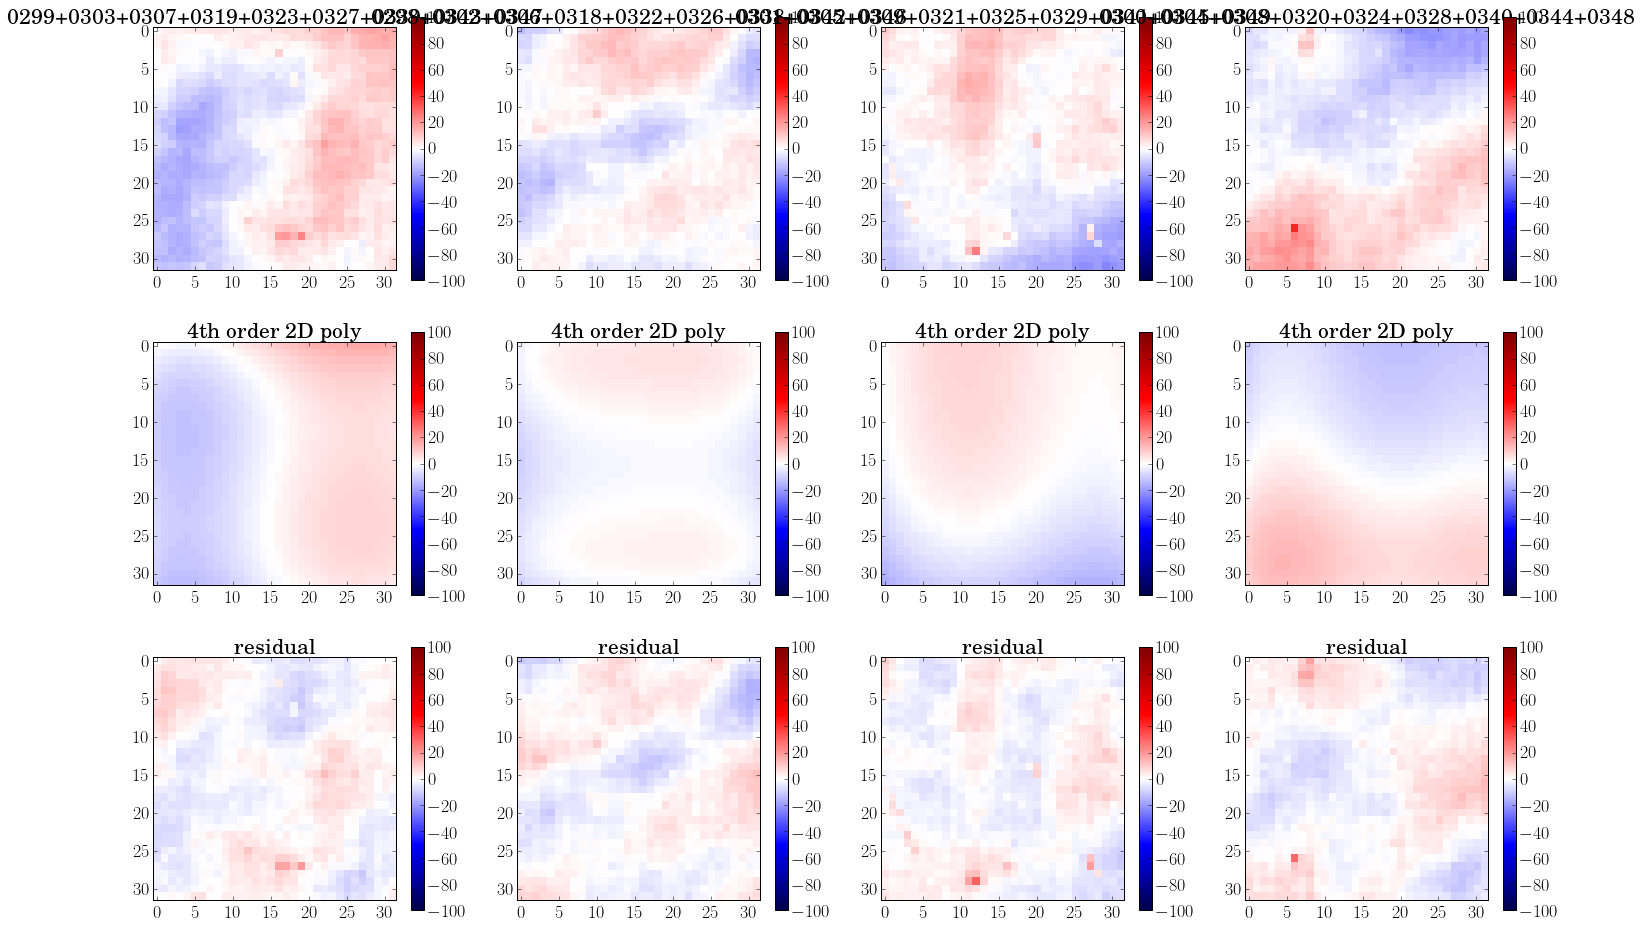

In [5]:
v1=-1.e2
v2=1.e2
cm = 'seismic'

plt.figure(figsize=(25,16))

for framei in range(num_frames):
    img = ir_images[framei].frame_kjy_per_sr
    model = ir_images[framei].model_frame_kjy_per_sr
    
    
    plt.subplot(3,num_frames,framei+1)
    plt.imshow(img-img.mean(),vmin=v1,vmax=v2,interpolation='nearest',cmap=cm)
    plt.colorbar()
    plt.title(analysis_names[framei].replace('_','+').replace('I',''))
    
    plt.subplot(3,num_frames,num_frames+framei+1)
    plt.imshow(model-model.mean(),vmin=v1,vmax=v2,interpolation='nearest',cmap=cm)
    plt.colorbar()
    plt.title('4th order 2D poly')
    
    plt.subplot(3,num_frames,2*num_frames+framei+1)
    plt.imshow(img-model,vmin=v1,vmax=v2,interpolation='nearest',cmap=cm)
    plt.colorbar()
    plt.title('residual')
    
#plt.tight_layout()

In [6]:
# LOAD LITERATURE IR POWER SPECTRA (Zemcov+ 14)

d = '/Users/abrahamn/Documents/MIT/21cm/21cmIR/2016/may/zemcov14_data/'
ell_Cell_ciber = genfromtxt(d+'zemcov14_CIBER_data_Cl.txt',skip_header=1,delimiter=',')
ell_Cell_eormodel = genfromtxt(d+'zemcov14_eor_Cl.txt',skip_header=1,delimiter=',')

# these are in nW/m^2/sr, but I want to convert them to kJy/sr
# I have to divide by the bandwidth of 0.5um
lamda_m = 1.1e-6
freq_Hz = 3.e8/lamda_m
convert_to_kJy_per_sr = 1.e-9/freq_Hz/(1.e3*1.e-26)

ell_Cell_ciber[:,1] *= convert_to_kJy_per_sr
ell_Cell_eormodel[:,1] *= convert_to_kJy_per_sr

In [7]:
nbins = 10
lmax = 2000

img.mean() = 3317.54
img.mean() = 3293.38
img.mean() = -2.27451892276e-05
img.mean() = 3063.56
img.mean() = 3040.78
img.mean() = 1.28585936738e-05
img.mean() = 3208.98
img.mean() = 3185.49
img.mean() = 6.68109440483e-06
img.mean() = 2926.21
img.mean() = 2904.08
img.mean() = -0.000137364583606


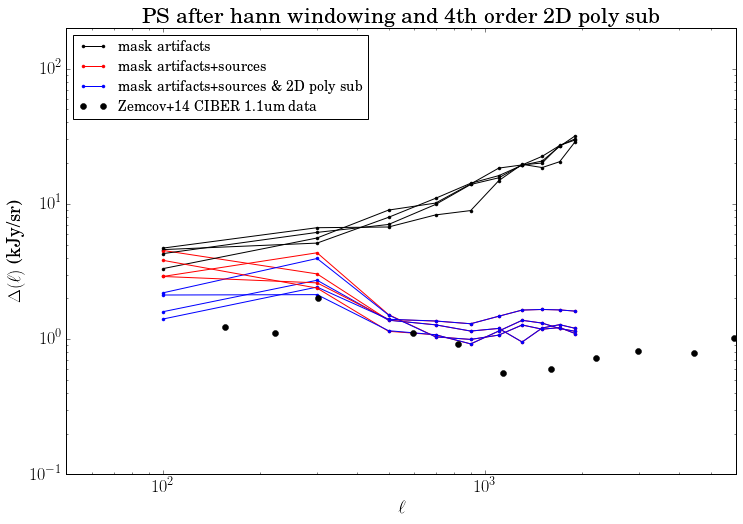

In [14]:
# MASKING STUDY: COMPARING POWER SPECTRA

imp.reload(ps_utils_new)

plt.figure(figsize=(12,8))
cols=['r','b']

plotlabels = ['mask artifacts','mask artifacts+sources','mask artifacts+sources \& 2D poly sub']
for framei in range(num_frames):
    if framei > 0: plotlabels = ['','','']
    lbins,Cl,counts = ps_utils_new.image2PS(ir_images_raw[framei],nbins,lmax,backsub=True,hann=True,use_res_image=False)
    plt.loglog(lbins,sqrt(lbins**2*Cl/(2*pi)),'k.-',label=plotlabels[0])
    
    lbins,Cl,counts = ps_utils_new.image2PS(ir_images[framei],nbins,lmax,backsub=True,hann=True,use_res_image=False)
    plt.loglog(lbins,sqrt(lbins**2*Cl/(2*pi)),'r.-',label=plotlabels[1])

    lbins,Cl,counts = ps_utils_new.image2PS(ir_images[framei],nbins,lmax,backsub=True,hann=True,use_res_image=True)
    plt.loglog(lbins,sqrt(lbins**2*Cl/(2*pi)),'b.-',label=plotlabels[2])
    
plt.loglog(ell_Cell_ciber[:,0],ell_Cell_ciber[:,1],'ko',label='Zemcov+14 CIBER 1.1um data')
#plt.loglog(ell_Cell_eormodel[:,0],ell_Cell_eormodel[:,1],'k--',label='Zemcov+14 EOR theory')

plt.xlabel('$\ell$')
plt.ylabel('$\Delta(\ell)$ (kJy/sr)')
plt.xlim([50,6000])
plt.ylim([.1,200])
plt.title('PS after hann windowing and 4th order 2D poly sub')
plt.legend(fontsize=14,loc=2)

#dark(title='Power spectra of ATLAS I band frames',fontsize=18)

plt.savefig('power_spectra_after_stacking_rereduction.pdf',bbox_inches='tight')

# plt.figure()
# plt.plot(lbins,counts0,'.-')


img.mean() = 3317.54
img.mean() = 3293.38
img.mean() = -2.27451892276e-05
img.mean() = 3063.56
img.mean() = 3040.78
img.mean() = 1.28585936738e-05
img.mean() = 3208.98
img.mean() = 3185.49
img.mean() = 6.68109440483e-06
img.mean() = 2926.21
img.mean() = 2904.08
img.mean() = -0.000137364583606


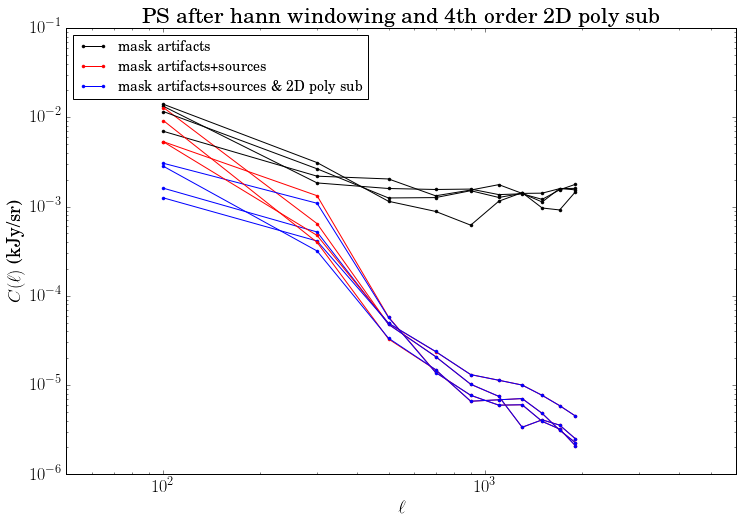

In [11]:
# MASKING STUDY: COMPARING POWER SPECTRA

imp.reload(ps_utils_new)

plt.figure(figsize=(12,8))
cols=['r','b']

plotlabels = ['mask artifacts','mask artifacts+sources','mask artifacts+sources \& 2D poly sub']
for framei in range(num_frames):
    if framei > 0: plotlabels = ['','','']
    lbins,Cl,counts = ps_utils_new.image2PS(ir_images_raw[framei],nbins,lmax,backsub=True,hann=True,use_res_image=False)
    plt.loglog(lbins,Cl,'k.-',label=plotlabels[0])
    
    lbins,Cl,counts = ps_utils_new.image2PS(ir_images[framei],nbins,lmax,backsub=True,hann=True,use_res_image=False)
    plt.loglog(lbins,Cl,'r.-',label=plotlabels[1])

    lbins,Cl,counts = ps_utils_new.image2PS(ir_images[framei],nbins,lmax,backsub=True,hann=True,use_res_image=True)
    plt.loglog(lbins,Cl,'b.-',label=plotlabels[2])
    

plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (kJy/sr)')
plt.xlim([50,6000])
#plt.ylim([.1,200])
plt.title('PS after hann windowing and 4th order 2D poly sub')
plt.legend(fontsize=14,loc=2)

#dark(title='Power spectra of ATLAS I band frames',fontsize=18)

#plt.savefig('power_spectra_after_binning_masking_cropping.pdf',bbox_inches='tight')

# plt.figure()
# plt.plot(lbins,counts0,'.-')



In [15]:
sum_full = np.sum(np.array([ir_images[i].full_kjy_per_sr for i in range(num_frames)]),axis=0)
weights_full = np.sum(np.array([ir_images[i].full_kjy_per_sr != 0 for i in range(num_frames)]),axis=0)
mean_full = sum_full/weights_full
mean_full[weights_full == 0] = 0

/Users/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


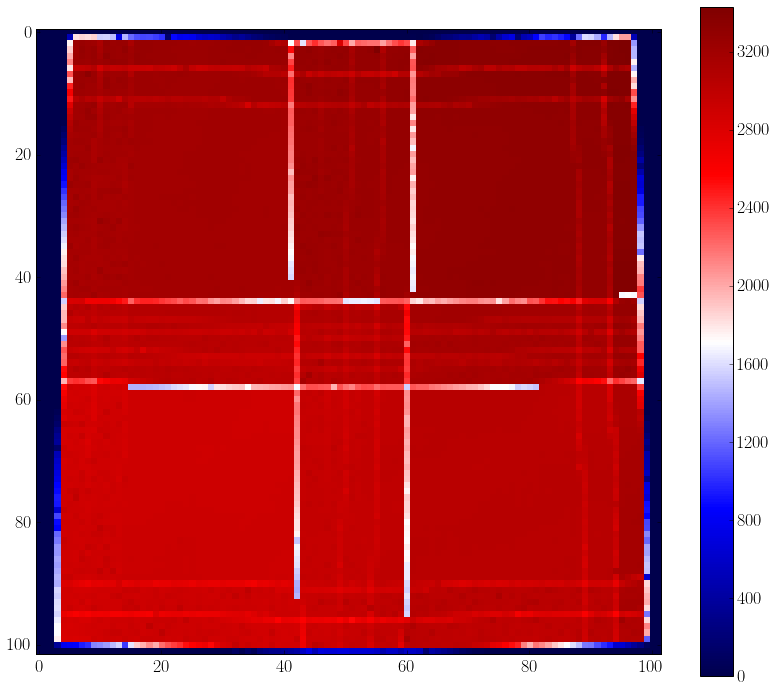

In [16]:
plt.figure(figsize=(14,12))
plt.imshow(mean_full,interpolation='nearest',cmap='seismic')
plt.colorbar()

In [17]:
fhdcubesroot = '/Volumes/abraham/xcor_data/fhd_cubes/fhd_apb_EoR0_high_sem1_1/'
fhdlabel = 'Combined_obs_golden' # 1068811656, Combined_obs_jd2456615_pointing0_wedge_cut, Combined_obs_golden, Combined_obs_wedge_cut_plus_res_cut

imp.reload(mwa_utils)
freq_averaged_cubedat0,freq_averaged_cubedat1 = mwa_utils.load_freq_averaged_odd_even_cubedat(fhdcubesroot,fhdlabel)

In [18]:
freq_averaged_cubedat0.keys()

['n_avg',
 'nside',
 'frequencies',
 'model_cube',
 'hpx_inds',
 'variance_cube',
 'dirty_cube',
 'weights_cube',
 'res_cube',
 'beam_squared_cube',
 'obs_arr']

In [19]:
np.sqrt(len(freq_averaged_cubedat0.weights_cube))

367.98505404431847

In [20]:
import healpy as hp
hp.nside2resol(1024)*180./np.pi

0.057258106863623433

In [21]:
.05725*367.98

21.066855

In [23]:
dtheta_amin_ir = ir_images[0].dtheta_deg*60
n_full_ir = ir_images[0].n_full
n_frame_ir = ir_images[0].n

imp.reload(mwa_utils)
mwa_image_full = mwa_utils.MWAImage(freq_averaged_cubedat0,freq_averaged_cubedat1, dtheta_amin_ir, int(10.*60/dtheta_amin_ir))
mwa_images = [mwa_utils.MWAImage(freq_averaged_cubedat0,freq_averaged_cubedat1, dtheta_amin_ir, n_full_ir,\
                                 crop_before_uniform_weighting_params=(n_frame_ir,ir_images[framei].x_med, ir_images[framei].y_med))\
              for framei in range(num_frames)]

initializing MWAImage object
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
psf is centered at (x,y) = (42,42)
applying uniform weighting
applying uniform weighting
applying uniform weighting
applying uniform weighting
initializing MWAImage object
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
psf is centered at (x,y) = (50,50)
cropping before applying uniform weighting
cropping to (29,70)
cropping to (29,70)
cropping to (29,70)
cropping to (29,70)
cropping to (50,50)
cropping to (50,50)
applying uniform weighting
applying uniform weighting
applying uniform weighting
applying uniform weighting
initializing MWAImage object
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
gridding healpix
psf is centered at (x,y) = (50,50)
cropping before apply

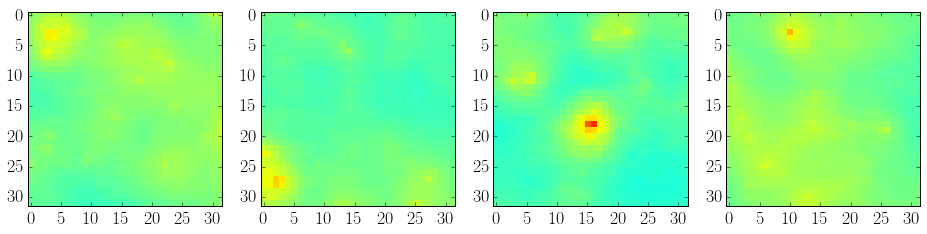

In [24]:
v1,v2 = -1.e7,1.e7
plt.figure(figsize=(16,4))
for i in range(num_frames):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx0,interpolation='nearest',vmin=v1,vmax=v2)

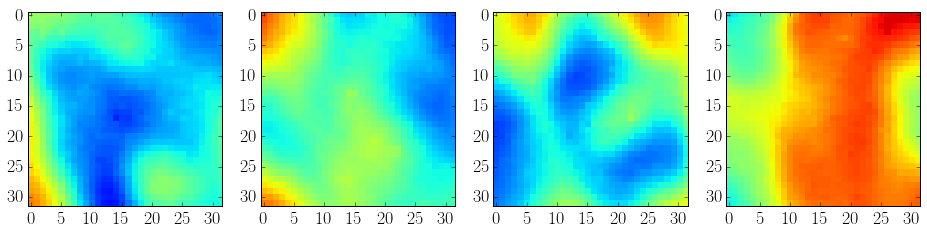

In [25]:
v1,v2 = -1.e6,1.e6
plt.figure(figsize=(16,4))
for i in range(num_frames):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx0-mwa_images[i].model_xx0,interpolation='nearest',vmin=v1,vmax=v2)

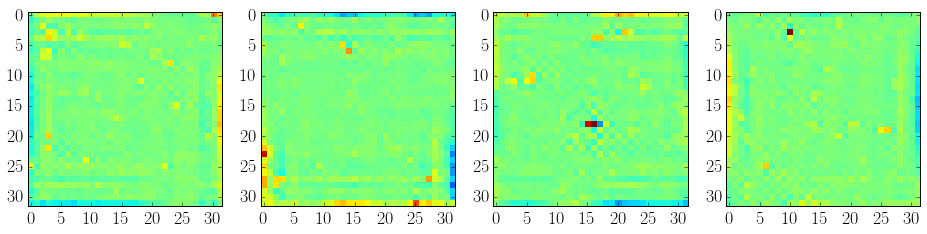

In [26]:
v1,v2 = -500,500
plt.figure(figsize=(16,4))
for i in range(num_frames):
    plt.subplot(1,num_frames,i+1)
    plt.imshow(mwa_images[i].dirty_xx_u0,interpolation='nearest',vmin=v1,vmax=v2)

(100.0, 3000.0)

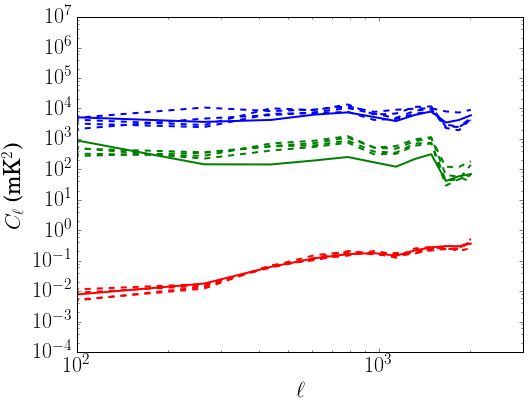

In [27]:
plt.figure(figsize=(8,6))

nbins = 12
lmax = 2100

imp.reload(mwa_utils)
lbincenters, Cl_dirty0, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0, mwa_image_full.weights_xx0, mwa_image_full.dtheta_rad, nbins,lmax, hann=False)
lbincenters, Cl_res0, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0 - mwa_image_full.model_xx_u0, mwa_image_full.weights_xx0,mwa_image_full.dtheta_rad, nbins,lmax, hann=False)
lbincenters, Cl_dirty_diff, bin_counts, bin_weights = mwa_utils.img2PS(mwa_image_full.dirty_xx_u0 - mwa_image_full.dirty_xx_u1, mwa_image_full.weights_xx0,mwa_image_full.dtheta_rad, nbins,lmax, hann=False)

plt.loglog(lbincenters,Cl_dirty0*1.e6,'b-',linewidth=2) # the 1.e6 converts from K to mK
plt.loglog(lbincenters,Cl_res0*1.e6,'g-',linewidth=2)
plt.loglog(lbincenters,Cl_dirty_diff*1.e6,'r-',linewidth=2)

for i in range(num_frames):
    lbincenters_frame, Cl_dirty0_frame, bin_counts_frame, bin_weights_frame = mwa_utils.img2PS(mwa_images[i].dirty_xx_u0, mwa_images[i].weights_xx0, mwa_images[i].dtheta_rad,nbins,lmax,hann=False)
    lbincenters_frame, Cl_res0_frame, bin_counts_frame, bin_weights_frame =     mwa_utils.img2PS(mwa_images[i].dirty_xx_u0 - mwa_images[i].model_xx_u0, mwa_images[i].weights_xx0,mwa_images[i].dtheta_rad, nbins,lmax, hann=False)
    lbincenters_frame, Cl_dirty_diff_frame, bin_counts_frame, bin_weights_frame =  mwa_utils.img2PS(mwa_images[i].dirty_xx_u0 - mwa_images[i].dirty_xx_u1, mwa_images[i].weights_xx0,mwa_images[i].dtheta_rad, nbins,lmax, hann=False)

    plt.loglog(lbincenters_frame,Cl_dirty0_frame*1.e6,'b--',linewidth=2)
    plt.loglog(lbincenters_frame,Cl_res0_frame*1.e6,'g--',linewidth=2)
    plt.loglog(lbincenters_frame,Cl_dirty_diff_frame*1.e6,'r--',linewidth=2)

matplotlib.rcParams.update({'font.size': 22})
plt.ylabel(r'$C_\ell$ (mK$^2$)')
plt.xlabel(r'$\ell$')
plt.ylim([1.e-4,1.e7])
#plt.ylim([10,1.e3])
plt.xlim([1.e2,3.e3])

2180.06087263
2180.06087263
2180.06087263
2180.06087263


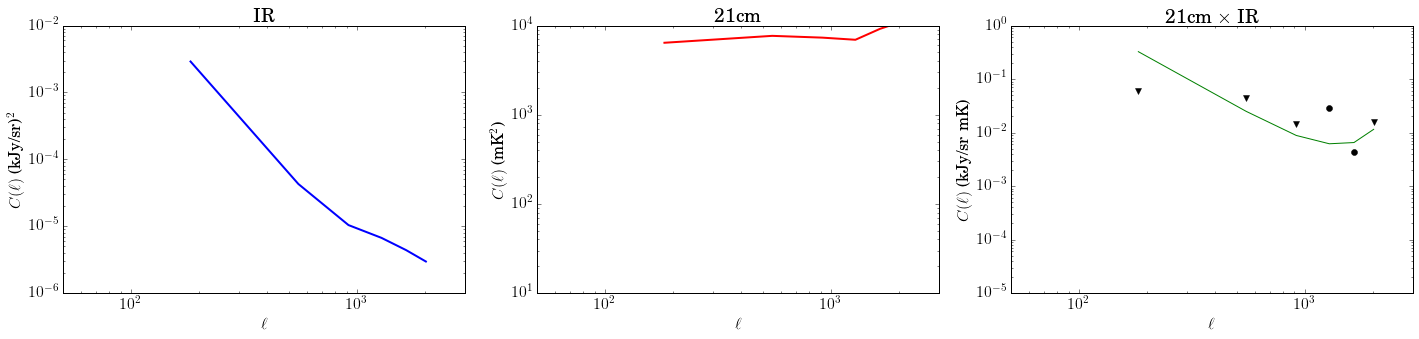

In [62]:
imp.reload(ps_utils_new)
irspecs = []
mwaspecs = []
xspecs = []
for framei in range(num_frames):
    lbins,irspec,mwaspec,xspec,bin_counts,bin_sum_weights,bin_sum_sq_weights = ps_utils_new.ir_and_radio_xspec(ir_images[framei],'',mwa_images[framei],'',nbins=6,lmax=2200,\
                                                                                                                         useirhann=True,usemwahann=True)
    irspecs.append(irspec)
    mwaspecs.append(mwaspec)
    xspecs.append(xspec)
irspecs,mwaspecs,xspecs = np.array(irspecs),np.array(mwaspecs),np.array(xspecs)
irspecs_mean = np.mean(irspecs,axis=0)
mwaspecs_mean = np.mean(mwaspecs,axis=0)
xspecs_mean = np.mean(xspecs,axis=0)


plt.figure(figsize=(20,5))
matplotlib.rcParams.update({'font.size': 16})

x1,x2 = 50,3000

plt.subplot(131)
#plt.loglog(lbins,irspecs[0],'b.-')
plt.loglog(lbins,irspecs_mean,'b-',linewidth=2)
plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (kJy/sr)$^2$')
plt.title('IR')
plt.xlim([x1,x2])
plt.ylim([1.e-6,1.e-2])

plt.subplot(132)
#plt.loglog(lbins,mwaspec,'r.-')
plt.loglog(lbins,mwaspecs_mean*1.e6,'r-',linewidth=2)
# plt.loglog(lbins,Cl_res0*1.e6,'g--')
plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (mK$^2$)')
plt.title('21cm')
plt.xlim([x1,x2])
plt.ylim([10,1.e4])

plt.subplot(133)
# ispos = xspecs[0]>0
# isneg = xspecs[0]<0
# plt.loglog(lbins[ispos],xspecs[0][ispos],'k.')
# plt.loglog(lbins[isneg],-xspecs[0][isneg],'kv')

ispos = xspecs_mean>0
isneg = xspecs_mean<0
plt.loglog(lbins[ispos],xspecs_mean[ispos]*1.e3,'ko')
plt.loglog(lbins[isneg],-xspecs_mean[isneg]*1.e3,'kv')
plt.loglog(lbins,np.sqrt(irspecs_mean*mwaspecs_mean)/np.sqrt(4*bin_counts)*1.e3,'g-')

plt.xlabel('$\ell$')
plt.ylabel('$C(\ell)$ (kJy/sr mK)')
plt.title(r'21cm $\times$ IR')
plt.xlim([x1,x2])
plt.ylim([1.e-5,1])

plt.tight_layout()

plt.savefig('radio_and_ir_xspec_allhann.pdf',bbox_inches='tight')

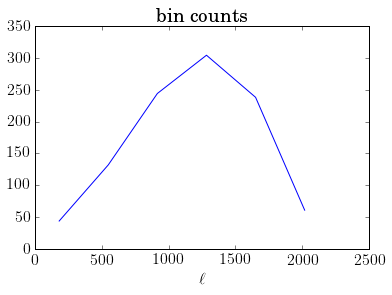

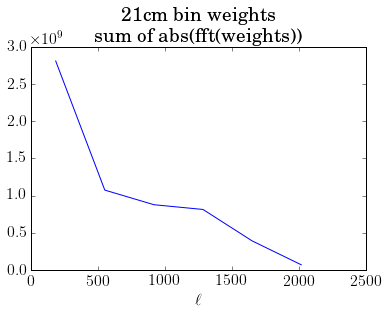

In [64]:
plt.figure()
plt.plot(lbins,bin_counts)
plt.xlabel(r'$\ell$')
plt.title('bin counts')

plt.figure()
plt.plot(lbins,bin_sum_weights)
plt.title('21cm bin weights \n    sum of abs(fft(weights)) ')
plt.xlabel(r'$\ell$')

In [31]:
# ispos = Cl_res_res>0
# isneg = Cl_res_res<0
# plt.plot(lbincenters[ispos],np.sqrt(lbincenters[ispos]**2/(2.*np.pi)*Cl_res_res[ispos]),'bo',linewidth=2)
# plt.plot(lbincenters[isneg],-np.sqrt(lbincenters[isneg]**2/(2.*np.pi)*np.abs(Cl_res_res[isneg])),'bo',linewidth=2)

# plt.ylabel(r'$\Delta(\ell)$ (kJy/sr $\cdot$ K)')
# plt.xlabel(r'$\ell$')